# ３章　word2vec

### 3.1.1　カウントベースの手法の問題点

単語の共起行列を作る上で、現実的な単語数では行列が巨大になりすぎる

・カウントベースの手法(バッチ学習)
→全ての学習データをまとめて処理(SVD)

・推論ベースの手法(ミニバッチ学習)
→学習データの一部を逐次的に学習(ニューラルネットワーク)

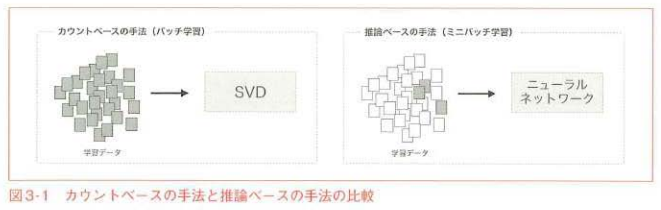

### 3.1.2　推論ベースの手法の概要

モデルが当てはまるであろう単語の出現確率を出力する。
その推論が正しくなるようにモデルを学習する。

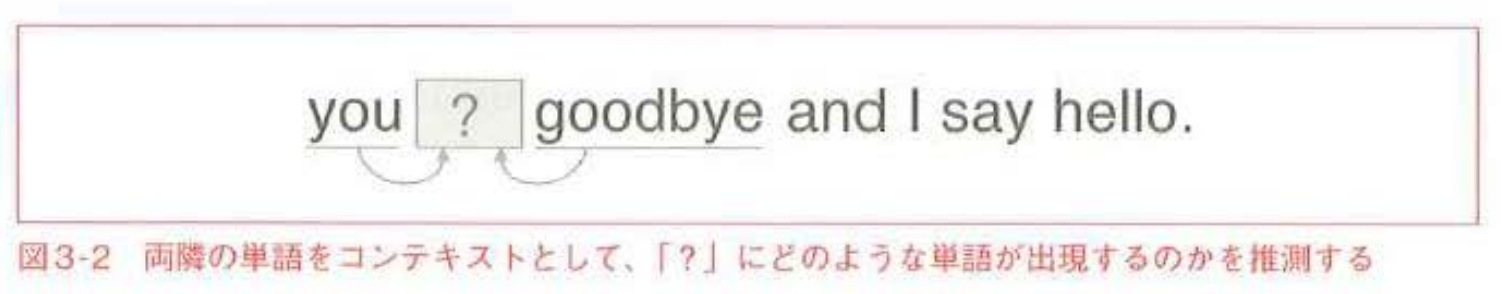

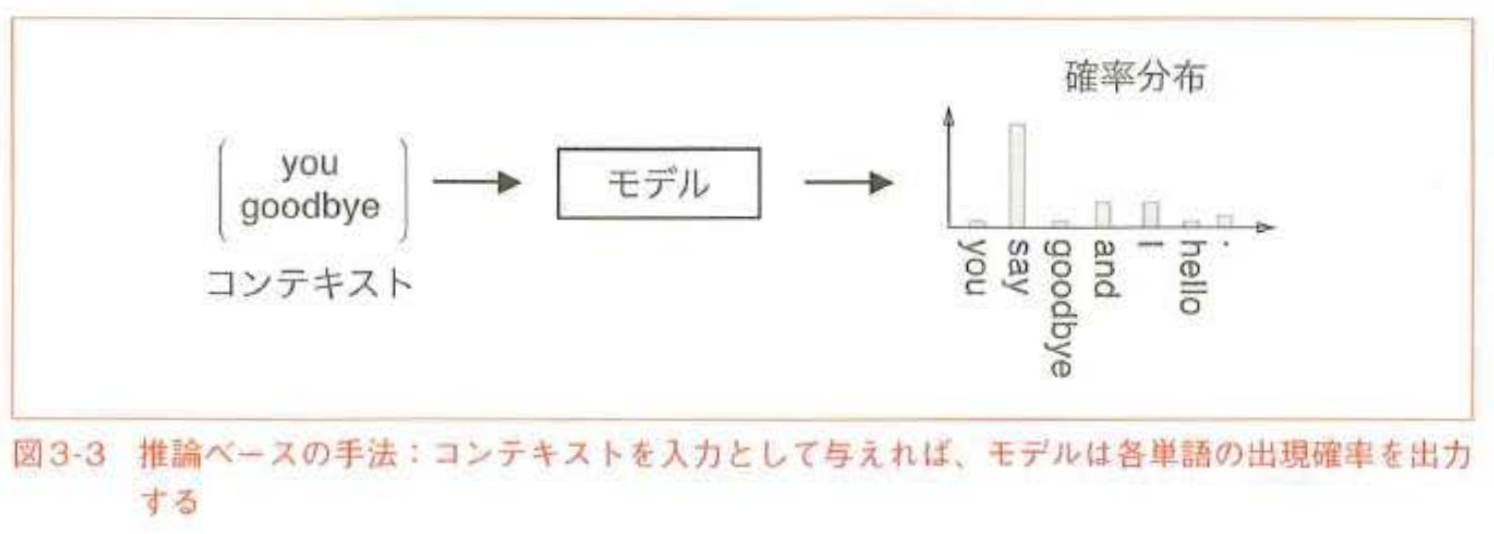

### 3.1.3　ニューラルネットワークにおける単語の処理方法

単語を「one-hot表現」というベクトル表現に変換する。

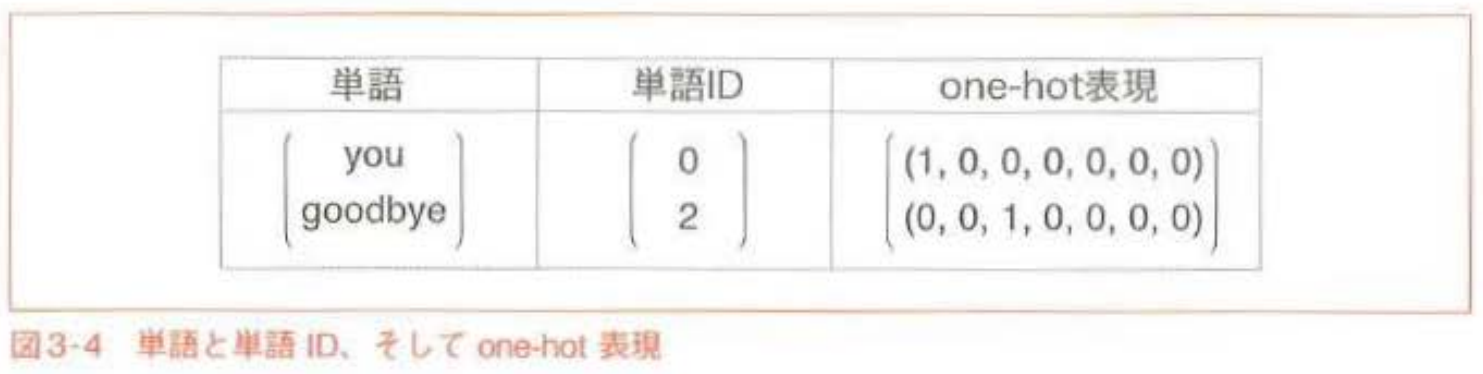

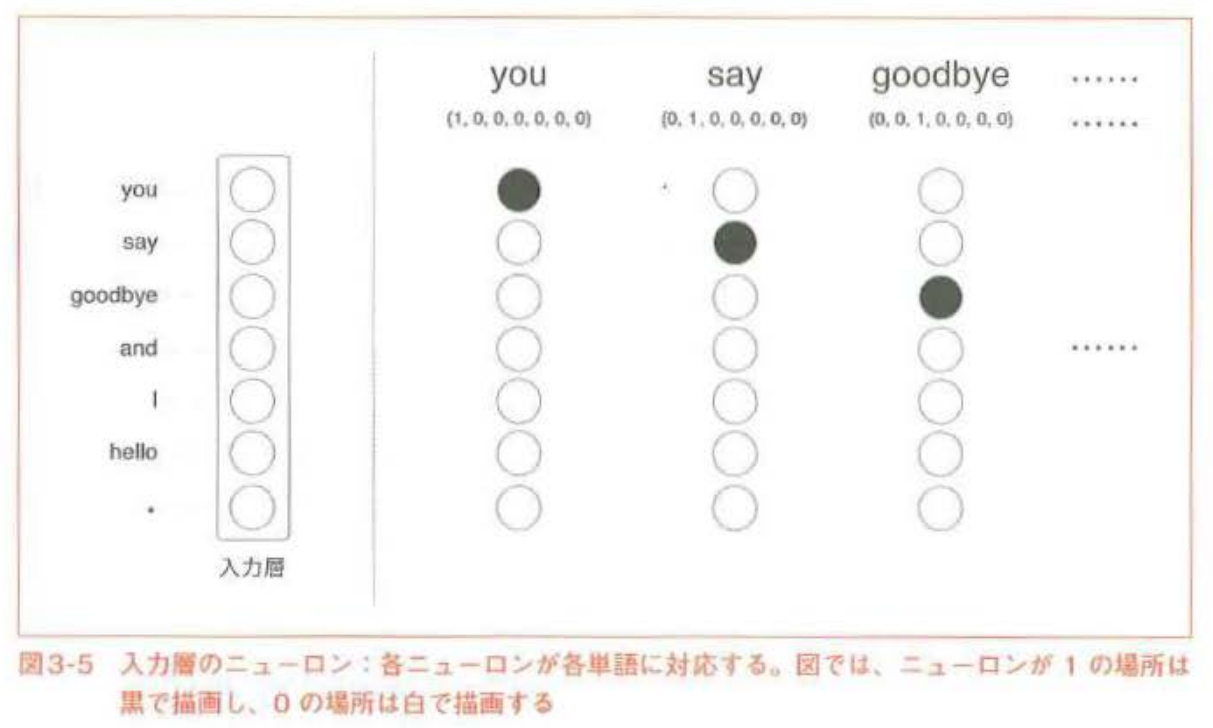

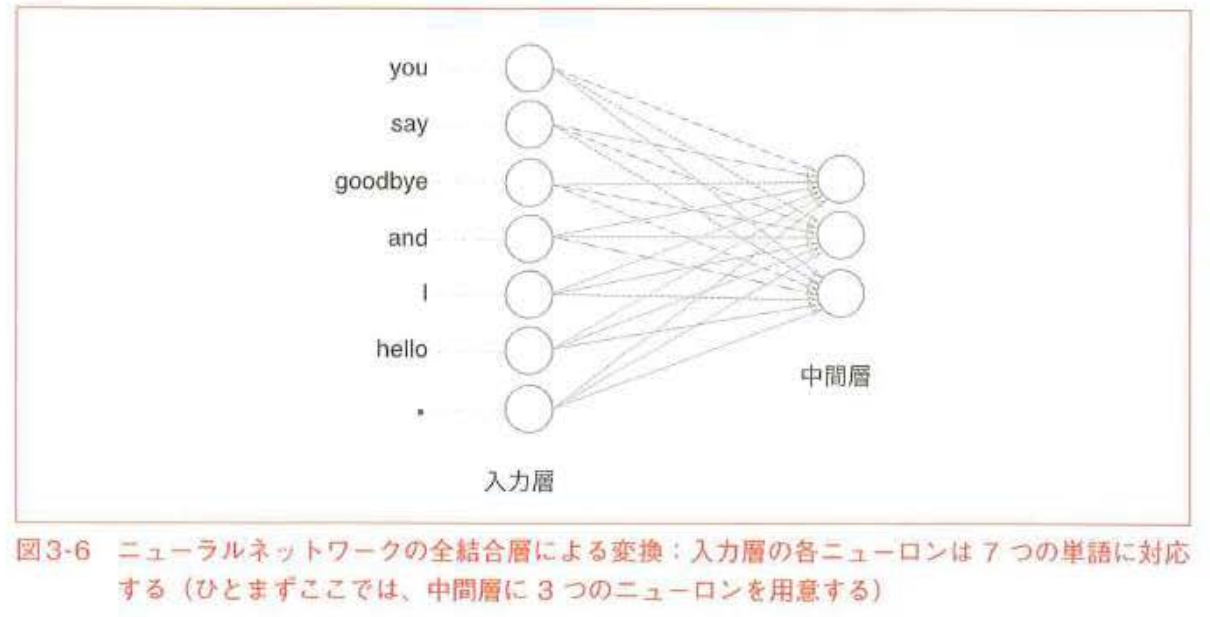

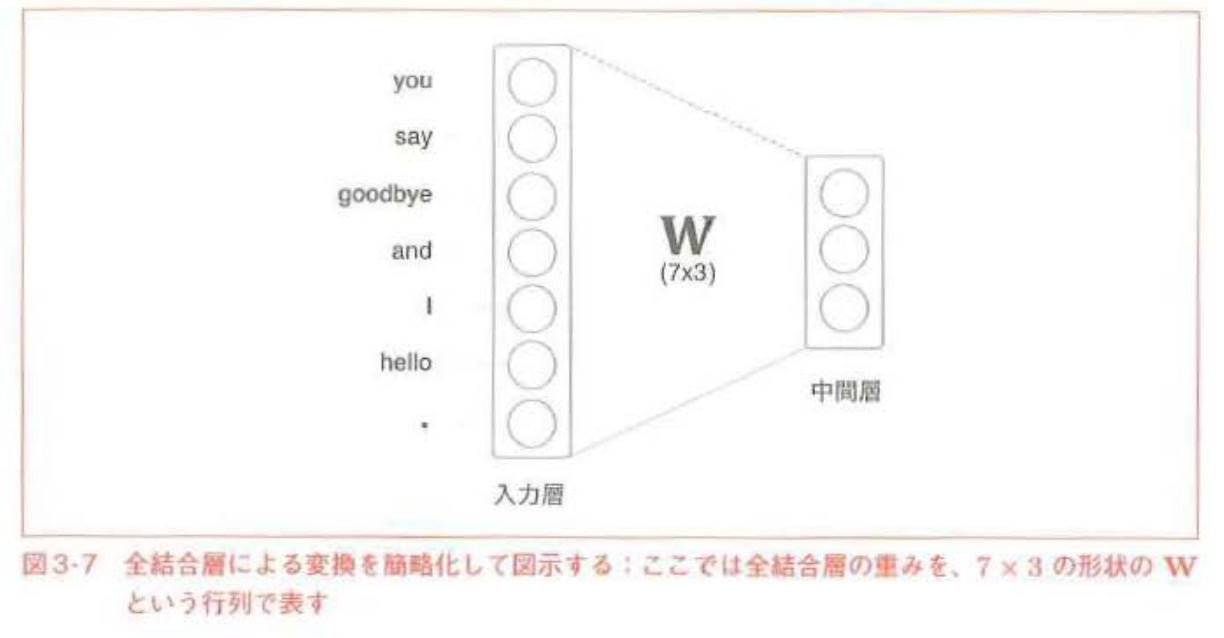

In [8]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # 入力
w = np.random.randn(7, 3)             # 重み
h = np.dot(c, w)                      # 中間ノード
print(h)

[[0.16551583 0.47098512 0.31632781]]


入力データの次元数は２
最初の次元（０次元目）にデータを格納

上のコードは下記の図３－８のように重みの行ベクトルを抜き出すことに相当

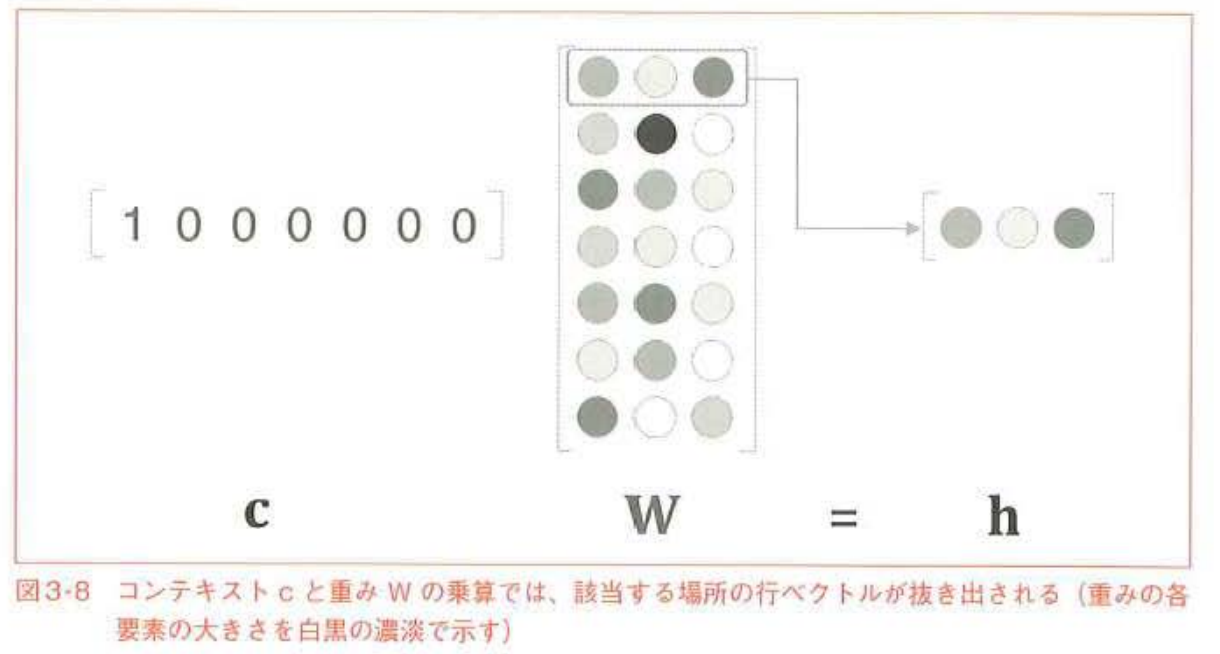

In [14]:
# MatMulレイヤによって実装
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
w = np.random.randn(7, 3)
layer = MatMul(w)
h = layer.forward(c)
print(h)

[[-1.35957325  1.70910253 -1.38299231]]


### 3.2 シンプルなword2vec

word2vecで提案されている「continuous bag-of-words(CBOW)」と呼ばれるモデルを使う

### 3.2.1　CBOWモデルの推論処理

・コンテキスト（中央周辺の単語）からターゲット（中央の単語）を推測することを目的としたニーラルネットワーク

・コンテキストとしてN個の単語
→入力層N個
(今回は２個の単語で考える)

・中間層のニューロンは各入力層の変換後の値が「平均」されたもの

・出力層のニューロンは「スコア」で、高いほどそれに対応する単語の出現確率が上がる
そのスコアに「softmax関数」を適用することで「確率」が得られる

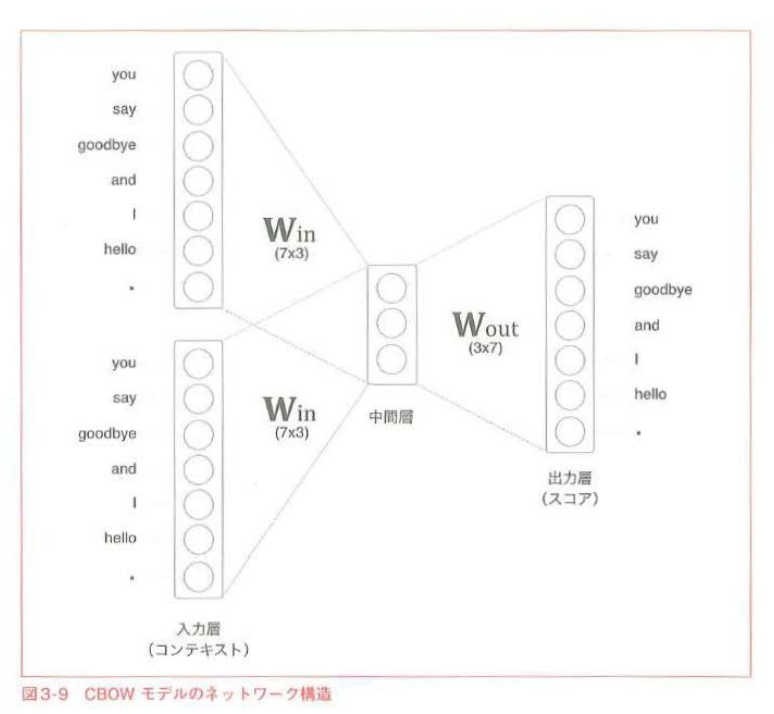

word2vecの全体像

重みの各行にそれぞれの単語の分散表現が格納されており、その中には「単語の意味」も含まれている

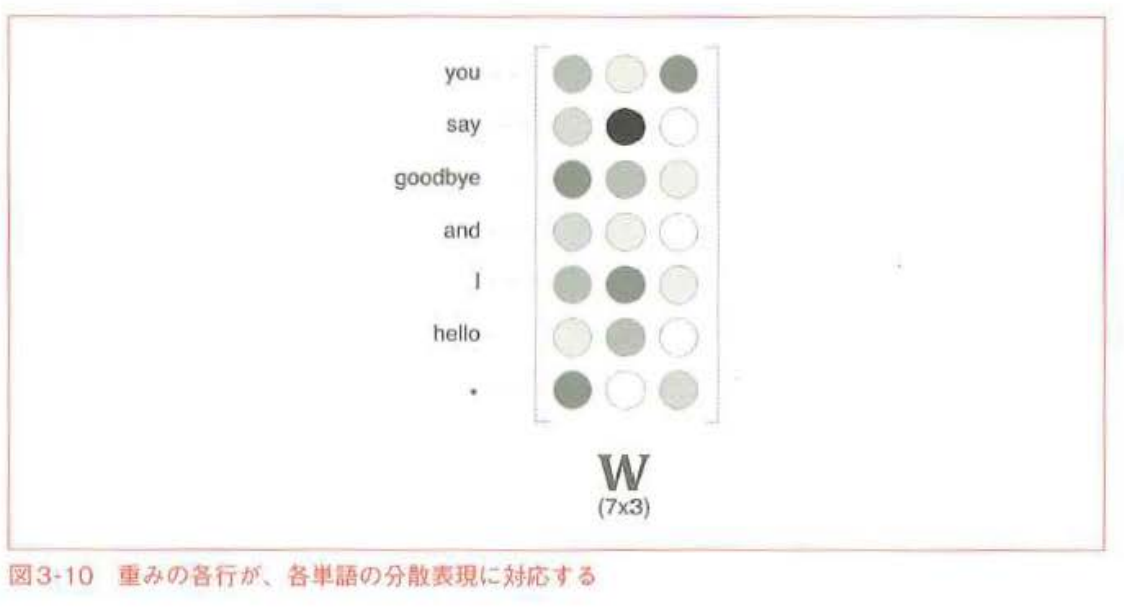

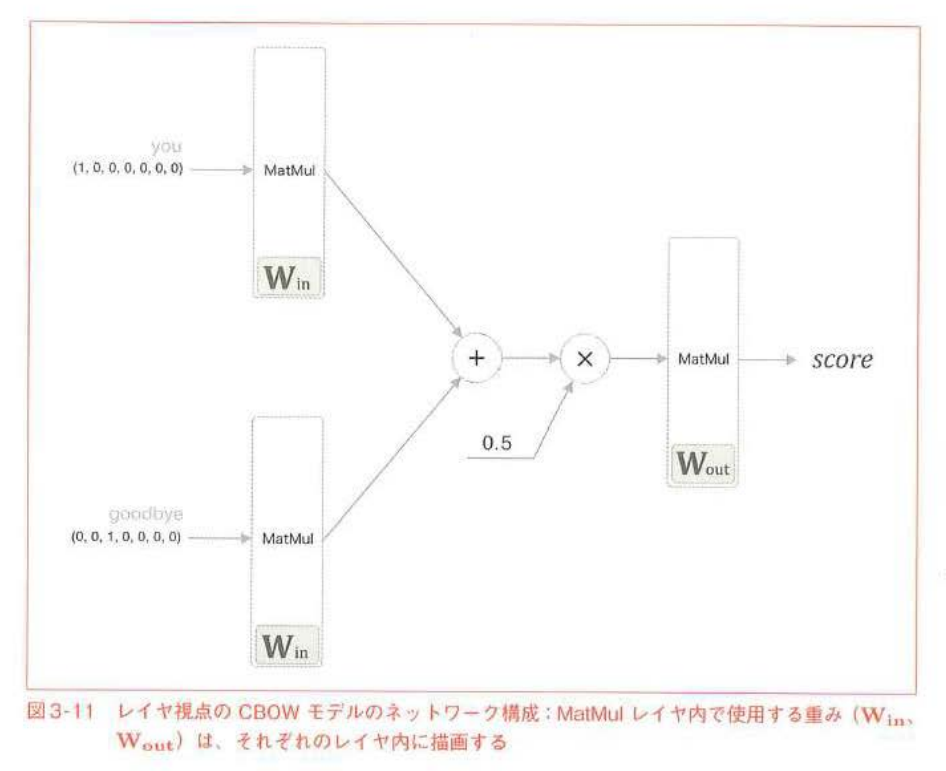

In [23]:
# CBOWモデルの推論処理

import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

# サンプルのコンテキストデータ
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 重みの初期化
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# レイヤの生成
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 順伝搬
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

# スコアの出力
print(s)

[[0.50946572 1.66119718 0.6638527  4.93726131 1.23689169 1.5406801
  3.79912148]]


### 3.2.2　CBOWモデルの学習

スコアをSoftmax関数で確率には変換し、その確率と教師ラベルから交差エントロピー(誤差)を求めて、それを損失として学習する

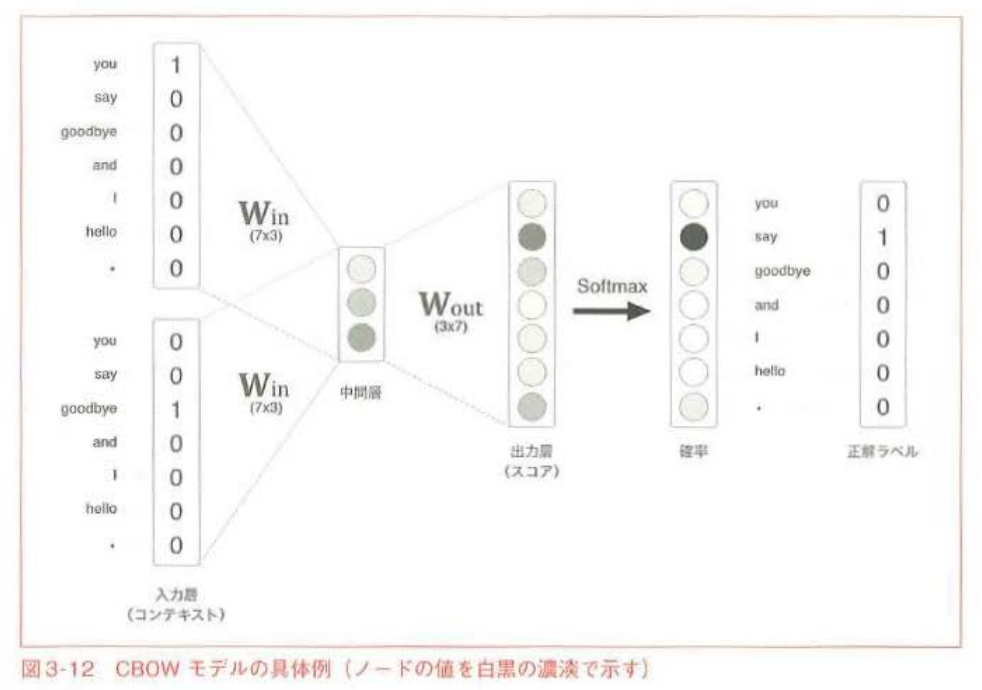

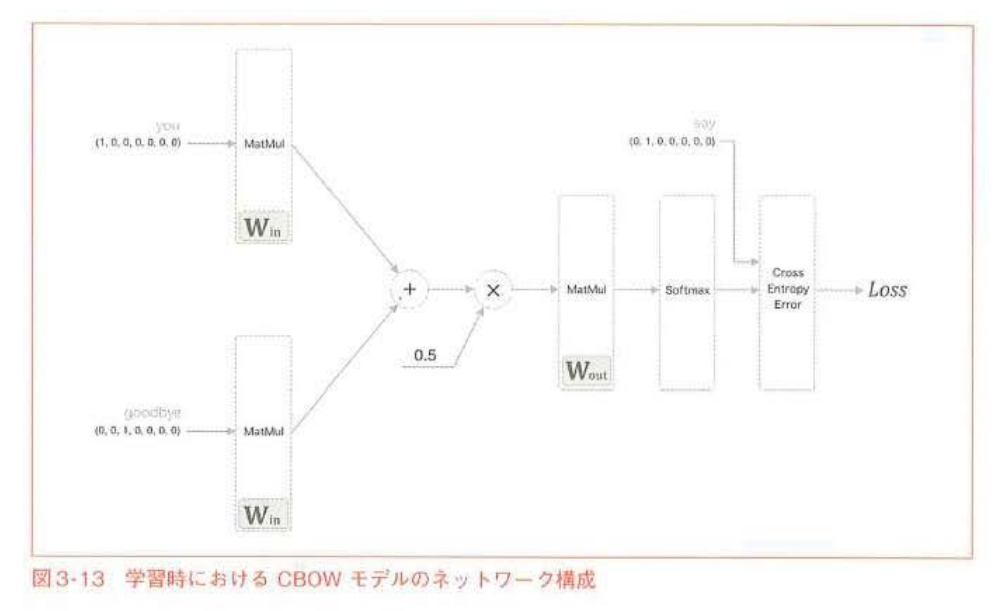

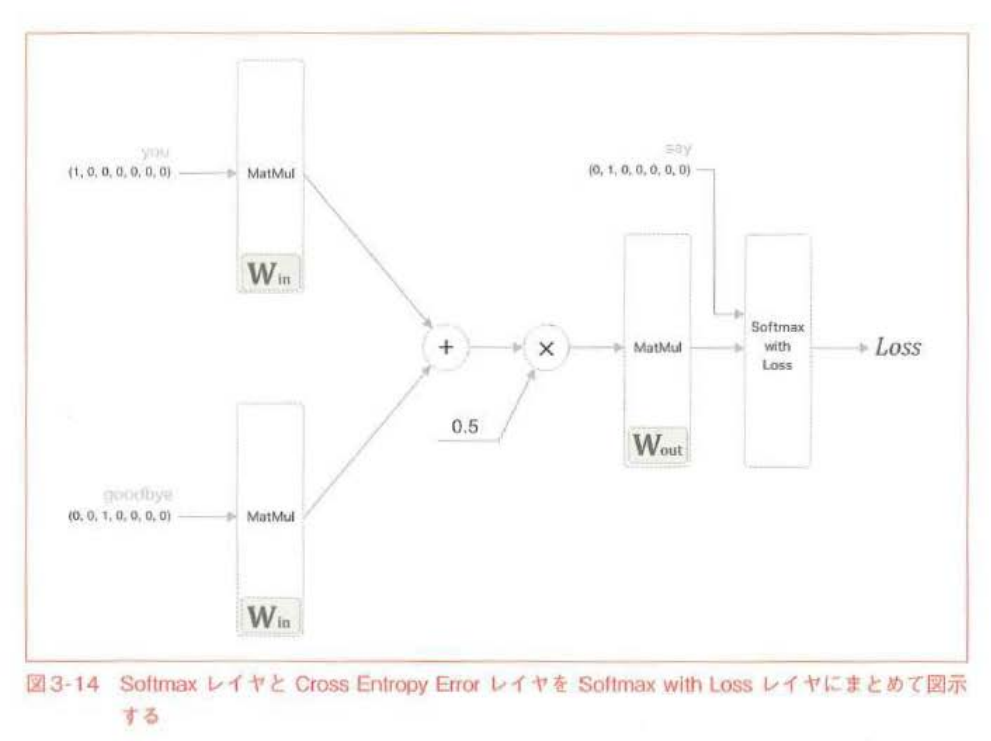

### 3.2.3　word2vecの重みと分散表現

word2vec(特にskip-gramモデル)に関して言うと
「入力側の重みだけを利用する」ことがポピュラーな選択肢

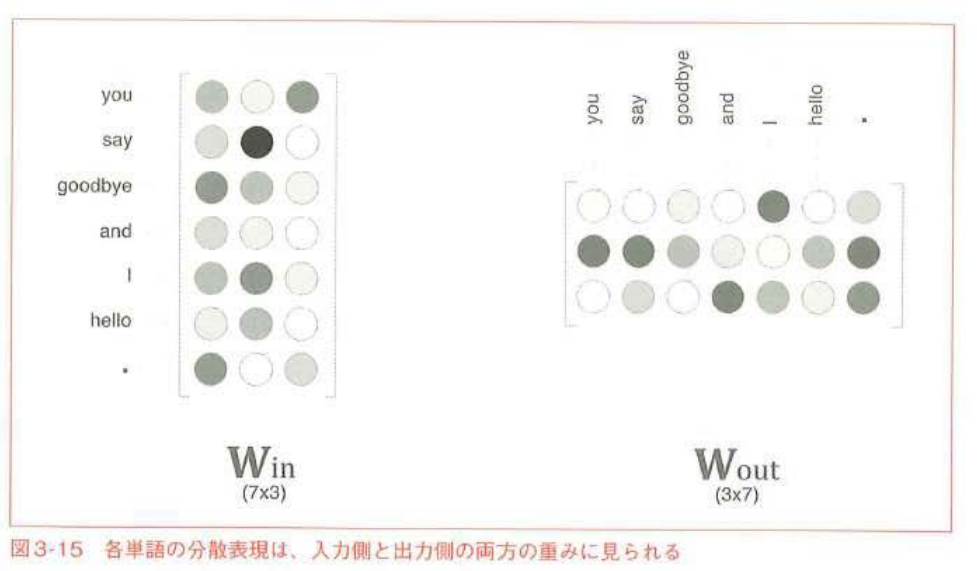

### 3.3　学習データの準備

### 3.3.1　コンテキストとターゲット

ゴールはニューラルネットワークに「コンテキスト」を入力したときに「ターゲット」が出現する確率を高めること


コーパスからコンテキストとターゲットを作成する関数を実装

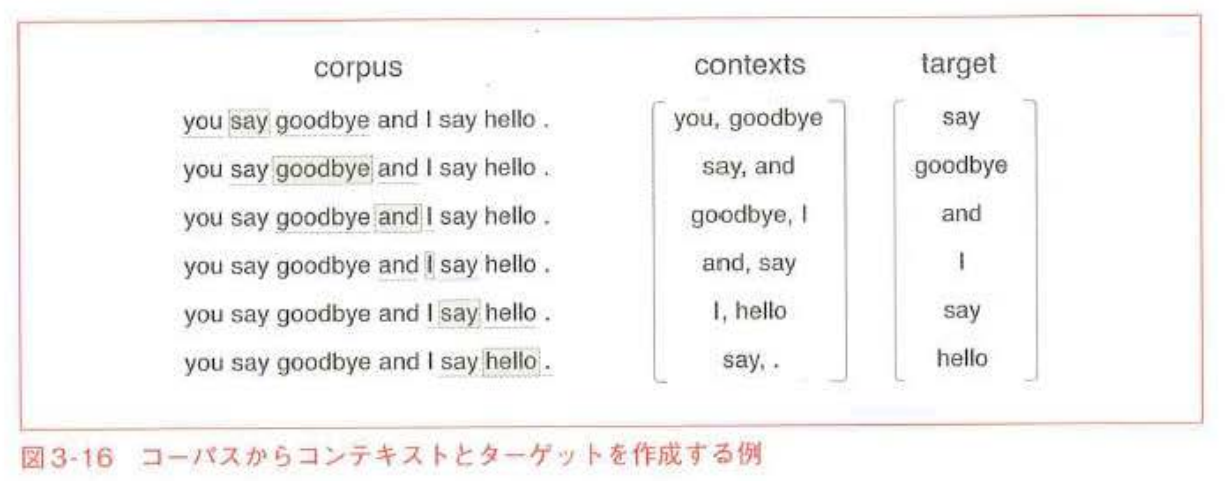

In [25]:
# preprocess関数

import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

[0 1 2 3 4 1 5 6]


In [26]:
print(id_to_word)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


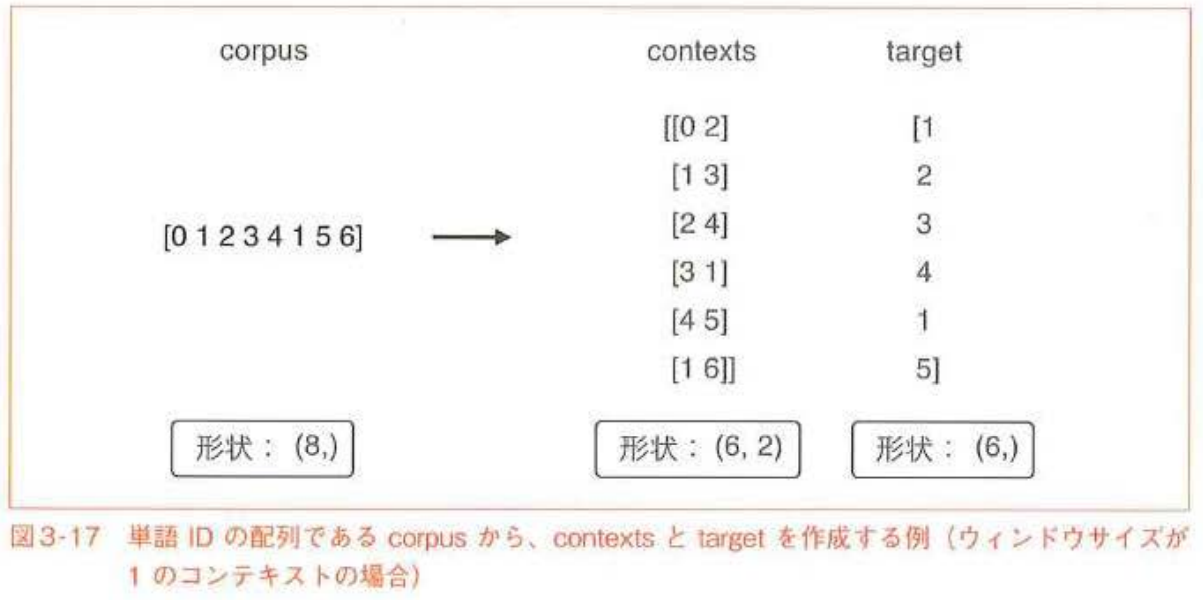

In [30]:
# コンテキストとターゲットを作成する関数

def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [31]:
contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]


In [32]:
print(target)

[1 2 3 4 1 5]


### 3.3.2　one-hot表現

コンテキストとターゲットを単語IDからone-hot表現へと変換

convert_one_hot()関数を使う

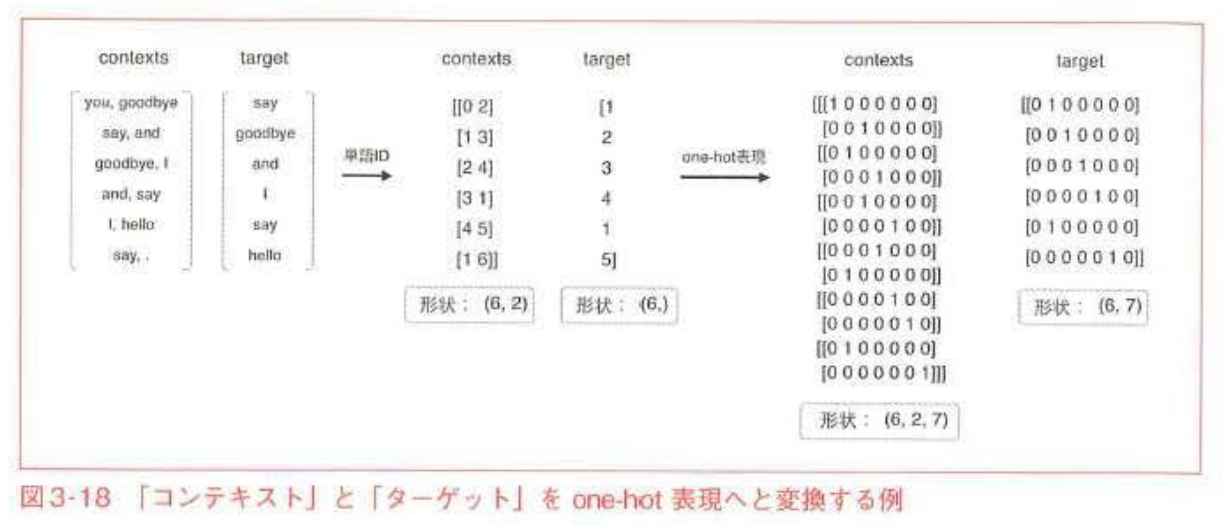

In [33]:
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target,convert_one_hot

text = 'You saｙ goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

### 3.4　CBOWモデルの実装

ニューラルネットワークをSimpleCBOWという名前で実装

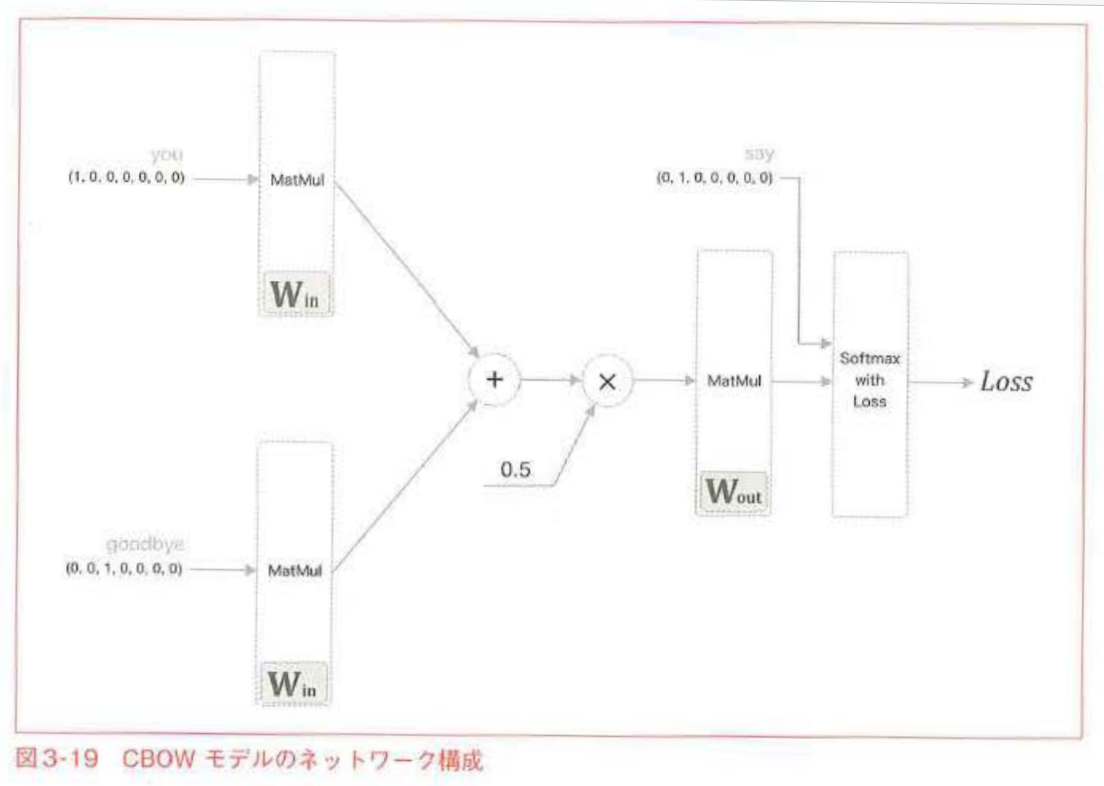

In [34]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

In [35]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

次にニューラルネットワークの順伝播であるforward()メゾッドを実装

In [36]:
def forward(self, contexts, target):
    h0 = self.in_layer0.forward(contexts[:, 0])
    h1 = self.in_layer1.forward(contexts[:, 1])
    h = (h0 + h1) * 0.5
    score = self.out_layer.forward(h)
    loss = self.loss_layer.forward(score, target)
    return loss

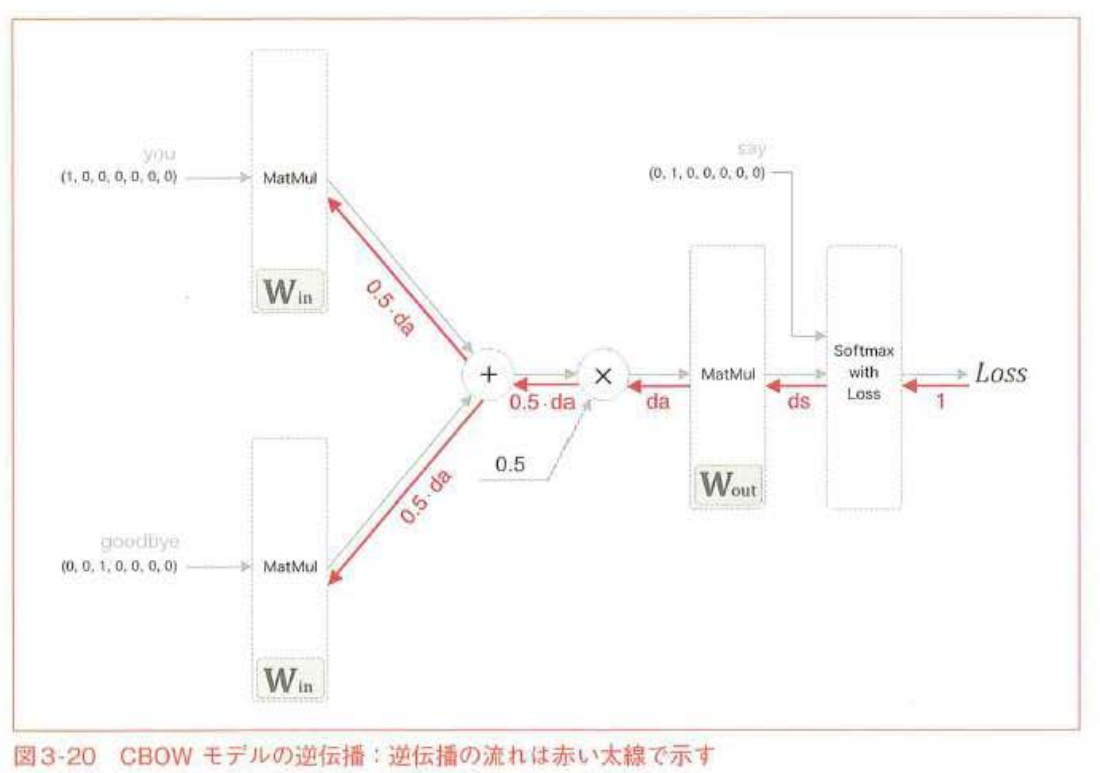

最後に逆伝播のbackward()を実装

In [37]:
def backward(self, dout=1):
    ds = self.loss_layer.backward(dout)
    da = self.out_layer.backward(ds)
    da *= 0.5
    self.in_layer1.backward(da)
    self.in_layer0.backward(da)
    return None

### 3.4.1　学習コードの実装

学習データを準備しニューラルネットワークに与える
そして、勾配を求めて重みパラメータを逐一アップデート

Trainerクラスに行わせる

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

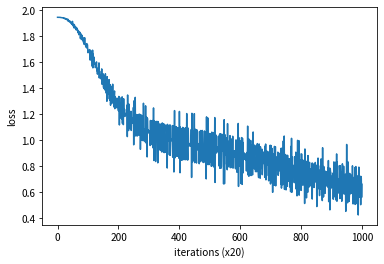

In [1]:
import sys
sys.path.append('..')  # 親ディレクトリのファイルをインポートするための設定
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

学習回数を重ねると損失が減少しているとわかる

In [5]:
# 学習が終わった後の重みパラメータ
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-1.1452595  1.1589766 -1.2143931  1.1327609  1.1617312]
say [ 1.1691381 -0.9252578  1.2417735 -1.2024627 -1.2082052]
goodbye [-0.6739606   0.96206367 -0.57552606  0.71228063  0.6651061 ]
and [ 1.4996679  1.3827504  1.293604  -1.2834429 -1.3115294]
i [-0.6864264   0.9644115  -0.556923    0.72312564  0.6663562 ]
hello [-1.142786   1.1596565 -1.2281762  1.1419419  1.1599857]
. [-0.05242852 -1.941259    0.6817193  -0.5885833  -0.58335996]


上記が単語の分散表現

ただしサイズの小さいコーパスでは良い結果は得られない

### 3.5　word2vecに関する補足

### 3.5.1　CBOWモデルと確率


Aという事象が起こる確率：P(A)

AとBが同時に起こる確率(同時確率)：P(A, B)

Bが与えられたときにAが起こる確率(事後確率)：P(A|B)

コンテキストw_t-1, w_t+1が与えられたときにターゲットがw_tとなる確率：P(w_t|w_t-1, w_t+1)

CBOWモデルの損失関数

→交差エントロピー誤差
L = -Σt_klogy_k
を当てはめると

L = -logP(w_t|w_t-1, w_t+1) (負の対数尤度)

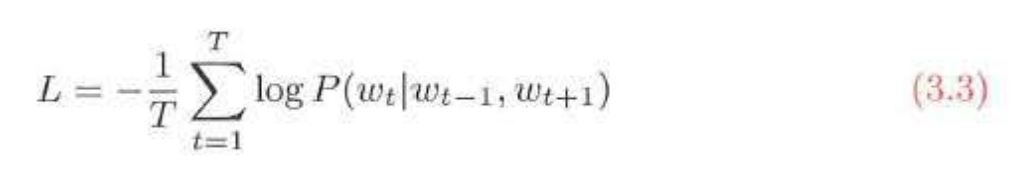

### 3.5.3 skip-gramモデル

CBOWモデルが複数のコンテキストからターゲット(中央の単語)を推測するのに対して、中央の単語(ターゲット)から周辺の複数の単語(コンテキスト)を推測する

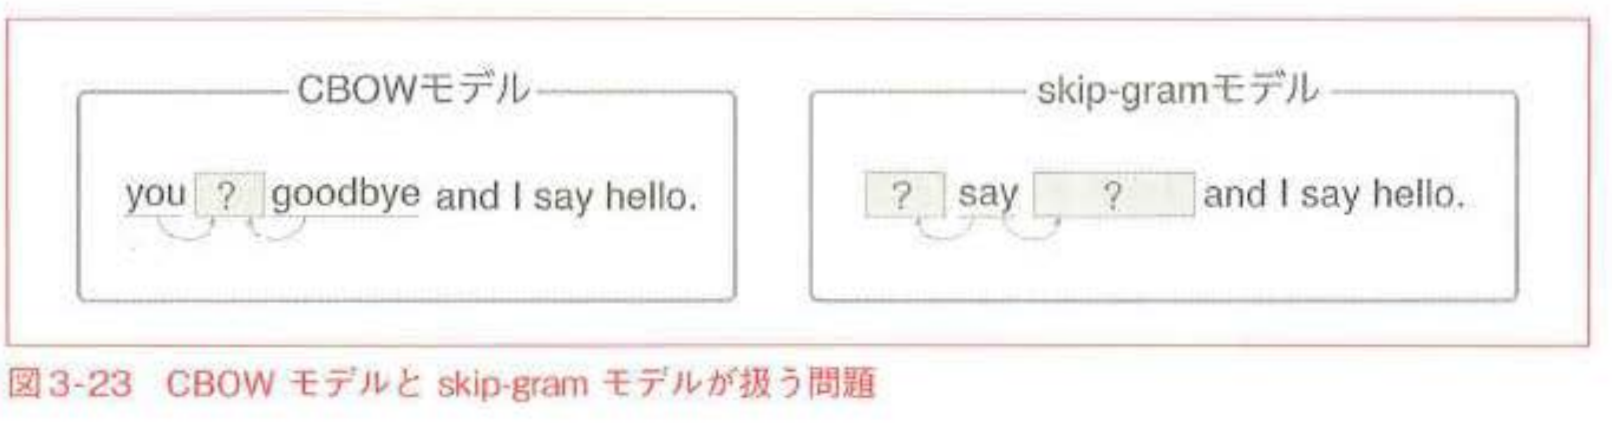

In [45]:
# skip-gramの実装
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None

### 3.5.3　カウントベース v.s 推論ベース

語彙に新しい単語を追加する場合

カウントベース
→ゼロから計算を行う

推論ベース(word2vec)
→これまで学習した重みを初期値として再学習できる(効率的)

実際には、単語の類似性に関する定量評価については、２つの手法に優劣をつけられない

### 3.6　まとめ

● 推論ベースの手法は、推測することを目標として、その副産物として単語の分散表現を得られる

● word2vecは推論ベースの手法であり、シンプルな２層のニューラルネットワークで構成される

● word2vecには、skip-gramモデルとCBOWモデルがある

● CBOWモデルは複数の単語（コンテキスト）からひとつの単話（ター
ゲット）を推測する

● skip-gramモデルは逆に、ひとつの単語（ターゲット）から複数の単語（コンテキス ト）を推測する

● word2vecは重みの再学習ができるため、単語の分散表蜆の更新や追加が効率的に行える
